In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from myfunk import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd()
path

'/Users/iZbra1/Documents/K2DS/Projects/Trupanion'

In [3]:
p2data = pd.read_csv(path+'/data/p2_data.csv', index_col = 0, encoding = "ISO-8859-1") #simplest text encoding
print(p2data.info())
print("\nData has {} unique Diagnosis".format(len(p2data.Diagnosis.unique())))
print("Data has {} unique ItemDescriptions".format(len(p2data.ItemDescription.unique())))
print("Data has {} unique PreventiveFlags:{} \n {}".format(len(p2data.PreventiveFlag.unique()),
                                                           p2data.PreventiveFlag.unique(), 
                                                           p2data.PreventiveFlag.value_counts()))
print("Data has {} null PreventiveFlags\n".format(p2data.PreventiveFlag.isnull().sum()))

data = p2data.loc[p2data.PreventiveFlag.notnull()]
# data = data.sample(frac=0.001)
print(data.shape)
p2data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 1 to 11000
Data columns (total 3 columns):
ItemDescription    11000 non-null object
Diagnosis          11000 non-null object
PreventiveFlag     10000 non-null float64
dtypes: float64(1), object(2)
memory usage: 343.8+ KB
None

Data has 2266 unique Diagnosis
Data has 10475 unique ItemDescriptions
Data has 3 unique PreventiveFlags:[ 0.  1. nan] 
 0.0    9322
1.0     678
Name: PreventiveFlag, dtype: int64
Data has 1000 null PreventiveFlags

(10000, 3)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


### EDA

In [8]:
# Find outliers
# "________" was found in the itemdescription, didnt got removed

In [5]:
eda_stemming_lemmatizing(data.ItemDescription.apply(lambda word: text_analysis(word)), 
                         data.Diagnosis.apply(lambda word: text_analysis(word)))


There are 4541 different words, numbers and symbols in the Item Description
There are 2029 different words, numbers and symbols in the Diagnosis
There are 4505 different words and numbers in the Item Description
There are 2006 different words and numbers in the Item Description
There are 4372 different lemmas, numbers and symbols in the Item Description
There are 1840 different lemmas, numbers and symbols in the Diagnosis
There are 4198 different stems & numbers in the Item Description
There are 1750 different stems & numbers in the Diagnosis
There are 4198 different stems of lemmas & numbers in the Item Description
There are 1736 different stems of lemmas & numbers in the Diagnosis


In [14]:
# Divide training / testing datasets

test = p2data.loc[p2data.PreventiveFlag.isnull()]
data = p2data.loc[p2data.PreventiveFlag.notnull()]

print(data.shape, test.shape)

(10000, 3) (1000, 3)


In [32]:
from nltk import word_tokenize, sent_tokenize
## ----  Statistics
# Length of ItemDescription in number of characters
ItemDescription_lengths = [len(item[1].ItemDescription) for item in data.iterrows()]
Diagnosis_lengths = [len(item[1].Diagnosis) for item in data.iterrows()]

# Distribution of number of sentences in Item Descriptions: 
sentence_count_per_item = [len(sent_tokenize(item[1].ItemDescription)) for item in data.iterrows()]
sentence_count_per_diagnosis = [len(sent_tokenize(item[1].Diagnosis)) for item in data.iterrows()]

# Word count in ItemDescription
ItemDescription_word_count = [len(word_tokenize(item[1].ItemDescription)) for item in data.iterrows()]
Diagnosis_word_count = [len(word_tokenize(item[1].Diagnosis)) for item in data.iterrows()]

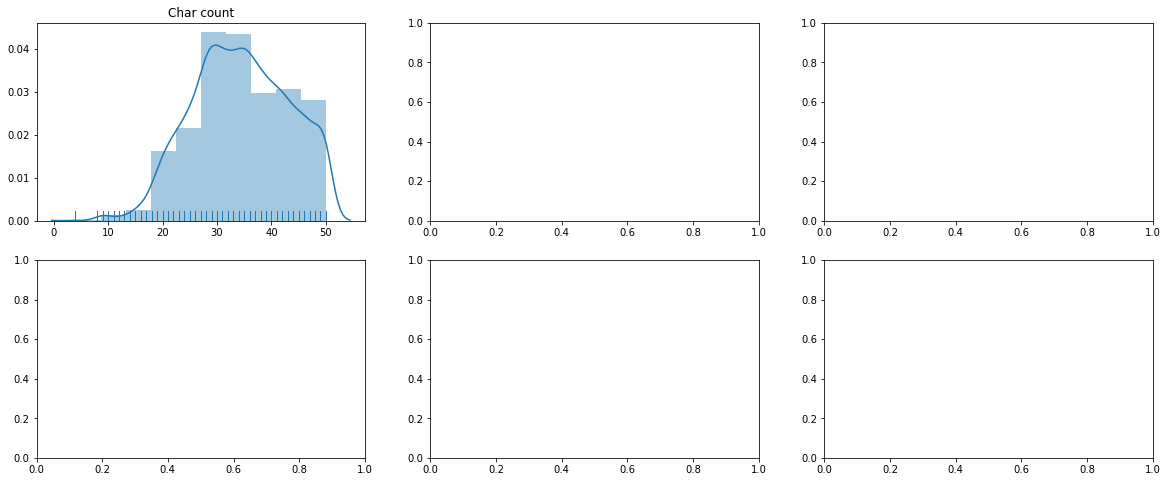

105.96142411231995


In [55]:
# create 3 subplots (horizontally stacked)    ~ 293 s
start = time()
f, axarr = plt.subplots(2,3,figsize=(20,8))

sns.distplot(ItemDescription_lengths, bins=10, rug=True, ax=axarr[0, 0], label="length")
axarr[0, 0].set_title('Char count')
sns.distplot(sentence_count_per_item, bins=10, rug=True, ax=axarr[0, 1], label="sentence count")
axarr[0, 1].set_title('Sentence count')
sns.distplot(ItemDescription_word_count, bins=10, ax=axarr[0,2], rug=True, label="word count")
axarr[0,2].set_title('Word count')

sns.distplot(Diagnosis_lengths, bins=10, rug=True, ax=axarr[1,0], label="length")
axarr[1,0].set_title('Diagnosis Char count')
sns.distplot(sentence_count_per_diagnosis, bins=10, rug=True, ax=axarr[1,1], label="sentence count")
axarr[1,1].set_title('Diagnosis Sentence count')
sns.distplot(Diagnosis_word_count, bins=10, ax=axarr[1,2], rug=True, label="word count")
axarr[1,2].set_title('Diagnosis Word count')

plt.show()
print(time()-start)
f.savefig('graphics/dataset_stats.png', dpi=f.dpi)

In [34]:
# Lets check the Item description and Diagnosis of instances of class 0
c0 = data.loc[data.PreventiveFlag==0.0]
# Length in characters
c0id_lengths = [len(item[1].ItemDescription) for item in c0.iterrows()]
c0d_lengths = [len(item[1].Diagnosis) for item in c0.iterrows()]
# Distribution of number of sentences in Item Descriptions: 
c0id_sentence = [len(sent_tokenize(item[1].ItemDescription)) for item in c0.iterrows()]
c0d_sentence = [len(sent_tokenize(item[1].Diagnosis)) for item in c0.iterrows()]
# Word count in ItemDescription
c0id_word = [len(word_tokenize(item[1].ItemDescription)) for item in c0.iterrows()]
c0d_word = [len(word_tokenize(item[1].Diagnosis)) for item in c0.iterrows()]

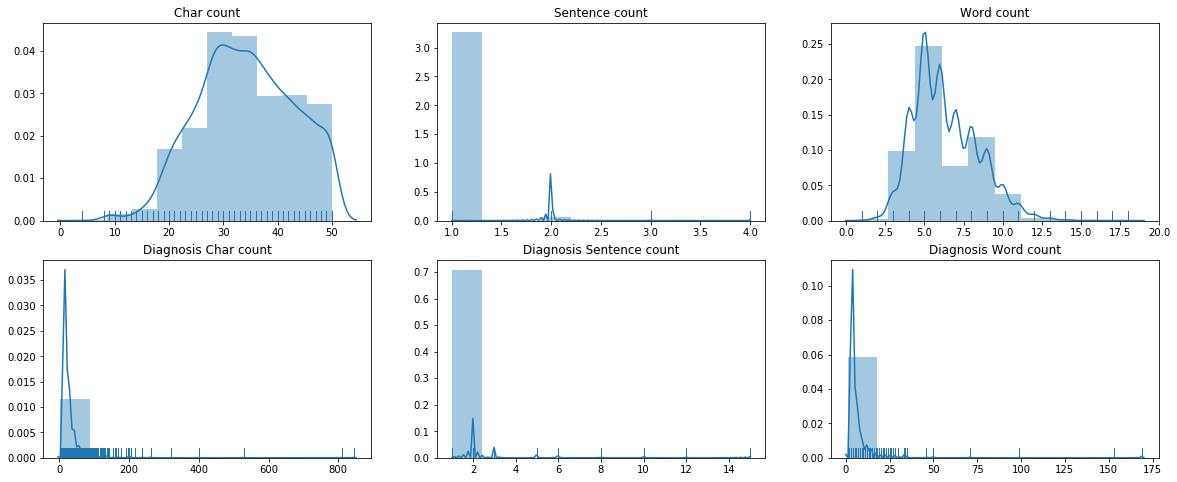

581.9781322479248


In [51]:
# create 3 subplots (horizontally stacked)    ~ 581 s ~ 10 min

f, axarr = plt.subplots(2,3,figsize=(20,8))

sns.distplot(c0id_lengths, bins=10, rug=True, ax=axarr[0, 0], label="length")
axarr[0, 0].set_title('Char count')
sns.distplot(c0id_sentence, bins=10, rug=True, ax=axarr[0, 1], label="sentence count")
axarr[0, 1].set_title('Sentence count')
sns.distplot(c0id_word, bins=10, ax=axarr[0,2], rug=True, label="word count")
axarr[0,2].set_title('Word count')

sns.distplot(c0d_lengths, bins=10, rug=True, ax=axarr[1,0], label="length")
axarr[1,0].set_title('Diagnosis Char count')
sns.distplot(c0d_sentence, bins=10, rug=True, ax=axarr[1,1], label="sentence count")
axarr[1,1].set_title('Diagnosis Sentence count')
sns.distplot(c0d_word, bins=10, ax=axarr[1,2], rug=True, label="word count")
axarr[1,2].set_title('Diagnosis Word count')

plt.show()

f.savefig('graphics/class0_stats.png', dpi=f.dpi)

Class 0 Item descritpion fields have a normal like distribution
The diagnosis however has a few outliers with a character length exceeding 200 
Some with over more than 6 sentences and words above 50 count. 

In [69]:
# round(
print("Average: {}".format(''.join(str(np.mean([c0id_lengths,
                     c0d_lengths, 
                     c0id_sentence, 
                     c0d_sentence, 
                     c0id_word, 
                     c0d_word], axis=1)))))
print("Median: {}".format(''.join(str(np.median([c0id_lengths,
                     c0d_lengths, 
                     c0id_sentence, 
                     c0d_sentence, 
                     c0id_word, 
                     c0d_word], axis=1)))))

Average: [34.21046986 23.76003004  1.02145462  1.03722377  6.35153401  3.53883287]
Median: [34. 16.  1.  1.  6.  2.]


In [120]:
print(c0.iloc[np.where(np.array(c0d_lengths) > 200)].Diagnosis.shape)

c0.iloc[np.where(np.array(c0d_lengths) > 200)].Diagnosis

(40,)


In [ ]:
# Lets check the Item description and Diagnosis of instances of class 1
c1 = data.loc[data.PreventiveFlag==1.0]
# Length in characters
c1id_lengths = [len(item[1].ItemDescription) for item in c1.iterrows()]
c1d_lengths = [len(item[1].Diagnosis) for item in c1.iterrows()]
# Distribution of number of sentences in Item Descriptions: 
c1id_sentence = [len(sent_tokenize(item[1].ItemDescription)) for item in c1.iterrows()]
c1d_sentence = [len(sent_tokenize(item[1].Diagnosis)) for item in c1.iterrows()]
# Word count in ItemDescription
c1id_word = [len(word_tokenize(item[1].ItemDescription)) for item in c1.iterrows()]
c1d_word = [len(word_tokenize(item[1].Diagnosis)) for item in c1.iterrows()]

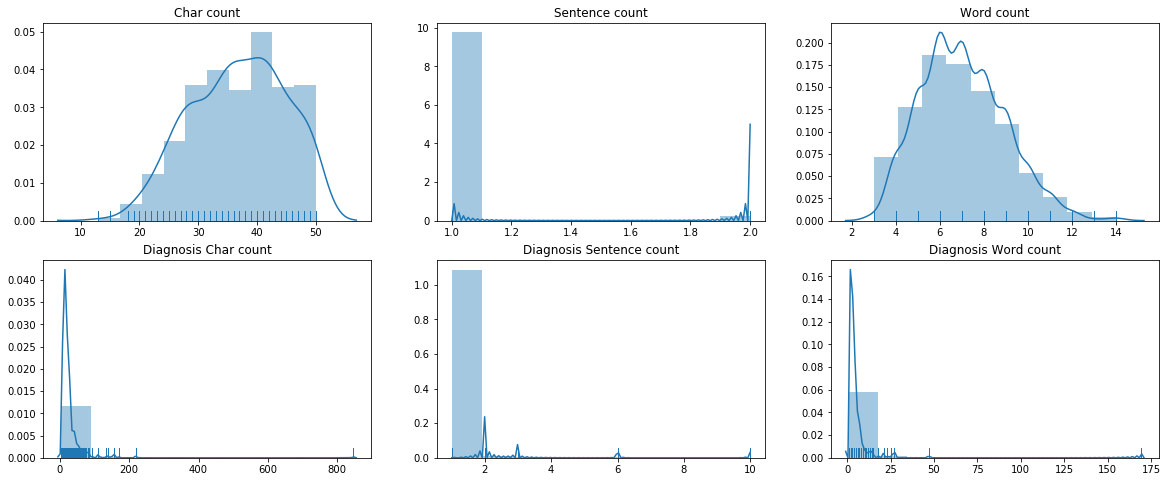

10.140615940093994


In [50]:
# create 3 subplots (horizontally stacked)    ~ 10 s

f, axarr = plt.subplots(2,3,figsize=(20,8))

sns.distplot(c1id_lengths, bins=10, rug=True, ax=axarr[0, 0], label="length")
axarr[0, 0].set_title('Char count')
sns.distplot(c1id_sentence, bins=10, rug=True, ax=axarr[0, 1], label="sentence count")
axarr[0, 1].set_title('Sentence count')
sns.distplot(c1id_word, bins=10, ax=axarr[0,2], rug=True, label="word count")
axarr[0,2].set_title('Word count')

sns.distplot(c1d_lengths, bins=10, rug=True, ax=axarr[1,0], label="length")
axarr[1,0].set_title('Diagnosis Char count')
sns.distplot(c1d_sentence, bins=10, rug=True, ax=axarr[1,1], label="sentence count")
axarr[1,1].set_title('Diagnosis Sentence count')
sns.distplot(c1d_word, bins=10, ax=axarr[1,2], rug=True, label="word count")
axarr[1,2].set_title('Diagnosis Word count')

plt.show()

f.savefig('/graphics/class1_stats.png', dpi=f.dpi)

In [133]:
print(c1.iloc[np.where(np.array(c1d_word) > 40)].Diagnosis.shape)
c1.iloc[np.where(np.array(c1d_word) > 40)]

(3,)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
340,Buttons: VACCINE CANINE EXAM + BORD,"HISTORY: Has emptied her AG a few times, usual...",1.0
772,Jack: Leptospirosis 1 Year Vaccination,"ulcerated dermal mass, periodontal diaease Wel...",1.0
773,Jack: Bordetella Intranasal Vaccination,"ulcerated dermal mass, periodontal diaease Wel...",1.0


In [70]:
print("Average: {}".format(''.join(str(np.mean([c1id_lengths,
                     c1d_lengths, 
                     c1id_sentence, 
                     c1d_sentence, 
                     c1id_word, 
                     c1d_word], axis=1)))))
print("Median: {}".format(''.join(str(np.median([c1id_lengths,
                     c1d_lengths, 
                     c1id_sentence, 
                     c1d_sentence, 
                     c1id_word, 
                     c1d_word], axis=1)))))

Average: [36.83923304 25.2979351   1.02359882  1.04867257  7.05014749  3.86873156]
Median: [37. 18.  1.  1.  7.  2.]


Class 1 
Char count: Diagnosis has an outlier with more than 800 characters in length
Must be the one having over 10 sentences and 170 words
Let's see which instances have a diagnosis word count of more than 30
On the ItemDescription side the fields seem to have in average 6 words and no more than 50 characters

In [ ]:
# Overall there are few outliers in the diagnosis feature. 
np.where(np.array(c1d_word) > 40)
np.where(np.array(c0d_lengths) > 200)
# I dont think removing them will affect the performance of the classification, given their number. 

---

In [5]:
# Is the data balanced? 
label_true = data.PreventiveFlag.value_counts()[1]
label_false = data.PreventiveFlag.value_counts()[0]
print("Data size {} \n {} Label 1 ({}) vs {} Label 0({})".format(
                                             str(data.shape),
                                             str(label_true/(label_false+label_true)),
                                             str(label_true), 
                                             str(label_false/(label_false+label_true)),
                                             str(label_false)))

# data = data.sample(frac=0.005)


Data size (10000, 3) 
 0.0678 Label 1 (678) vs 0.9322 Label 0(9322)


#### Init

In [8]:
## --- Variables
ng = 1
lemaVsStem = 0 # [0 for Lemming, 1 for stemming and 2 for both]

train_val_ratio = 0.3
seed = 42 # To minimize the sampling variation. 
np.random.seed(seed)
optimal_ratios = [0.143,0.1]
n_models = 3
clfs = {
    'clf_1':LogisticRegression(random_state=seed),
    'clf_2':RandomForestClassifier(random_state=seed), #DecisionTreeClassifier(random_state=seed),
    'clf_3':SGDClassifier(loss='log',random_state=seed)}

# Start! 
for ng in range(1,4):
    for lemaVsStem in range(3):
        # Masterscript
        flags = {'lemStem':lemaVsStem, 
                 'optimalRatio':optimal_ratios,
                 'trainValRatio': train_val_ratio, 
                 'n-grams': ng, 
                 'N_Models':n_models,
                 'rndseed':seed, 
                 'name':'RF'+str(ng)+"_"+str(lemaVsStem)
                }

        trupanion(data, clfs, flags)


Lemmatizing...
Training and Validation set sizes:  (7000, 4853) (7000,) (3000, 4853) (3000,)
Datasets sizes:
 (1396, 4853) (1115, 4853) (5413, 4853)
Training...

Done in 56 seconds

Stemming...
Training and Validation set sizes:  (7000, 4715) (7000,) (3000, 4715) (3000,)
Datasets sizes:
 (1396, 4715) (1115, 4715) (5413, 4715)
Training...

Done in 18 seconds

Lemmatizing...
Stemming...
Training and Validation set sizes:  (7000, 4702) (7000,) (3000, 4702) (3000,)
Datasets sizes:
 (1396, 4702) (1115, 4702) (5413, 4702)
Training...

Done in 44 seconds



#### Model selection


In [17]:

from sklearn.model_selection import GridSearchCV

param_dt = {'max_leaf_nodes': list(range(2, 100, 20)), 
           'min_samples_split': [2, 3, 4],
           'max_depth':[2,4,6]}
param_rf = { 
            'n_estimators': [25, 50],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,7,8],
            'criterion' :['gini', 'entropy']
} # 978s
param_lr  = {'penalty':["l1","l2"], 'class_weight':[None,'balanced']}
param_sgd = {'penalty':["l1","l2","elasticnet"],
               'learning_rate':['optimal'], 
               'loss':["log","modified_huber"], 
               'max_iter':[i for i in range(2,7,2)]}

params = {'1':param_lr,
          '2':param_rf,
          '3':param_sgd}

clfs = {
    'clf_1':LogisticRegression(random_state=seed),
    'clf_2':RandomForestClassifier(random_state=seed), #DecisionTreeClassifier(random_state=seed),
    'clf_3':SGDClassifier(loss='log',random_state=seed)}

#### GridSearch


In [115]:
# Hypertune a single classifier

start = time()
dbase = 2 # ID number of dataset
rfc = RandomForestClassifier(random_state=seed)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_rf, cv= 3, n_jobs=-1)
CV_rfc.fit(Xtr[str(dbase)], ytr[str(dbase)])

print("{:.0f} seconds".format(time()-start))

# Update the classifier with the optimal params
clfs['clf_'+str(dbase)].set_params(**CV_rfc.best_params_)

978.4219751358032


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 25}

In [70]:
# Hypertune the whole set of classifiers

start = time() # ~86s

grid_search_cv = {}
for i in range(1,n_models+1):
    grid_search_cv['clf_'+str(i)] = GridSearchCV(clfs['clf_'+str(i)], params[str(i)], n_jobs=-1)
    grid_search_cv['clf_'+str(i)].fit(Xtr[str(i)], ytr[str(i)])
    
    # Update the classifiers with the optimal parameters
    clfs['clf_'+str(i)].set_params(**grid_search_cv['clf_'+str(i)].best_params_)
    
#     print(grid_search_cv['clf_'+str(i)].best_estimator_)

print("{:.0f} seconds".format(time()-start))

86.30142211914062


Testing the baseline of classifiers with default parameters show scores higher (~0.068) than of its optmized homologue. And the Hard voting method outperforms the soft method (~0.048). 
Optimal n for n-grams is 2. 
Lemmatizing is prefered over stemming. And ngrams of 3 -4 lemmas yields high results. 
Switching the Decision trees classifier with a Random forest yielded interesting results. The default RF outweighed the gridsearch RF

---
The following script assumes: 
    - the dataset is balanced so best is to put it all in a pipeline
    - Uses optimized classifiers

In [20]:
# Optimal classifiers. 
clf1 = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=42, min_samples_split=2, random_state=42)
clf2 = SGDClassifier(learning_rate='optimal', loss='log', max_iter=4, penalty='l1', random_state=42)
clf3 = LogisticRegression(class_weight='balanced', random_state=42)

clfs = [
    ("DecTree", clf1),
    ("SVMwithSGD", clf2),
    ("LogReg", clf3)
]


mixed_pipe = Pipeline([
    ("voting", VotingClassifier(clfs, voting="soft"))
])

start = time()

mixed_pipe.fit(X_train, y_train)
y_val_pred = mixed_pipe.predict(X_val)

# These predictions can then be used to evaluate the classifier:

# y_train_scores = cross_val_score(mixed_pipe, X_train, y_train, cv=10)
y_train_pred = cross_val_predict(mixed_pipe, X_train, y_train, cv=10)

print("{:.0f} seconds".format(time()-start))

res = get_metrics(pd.DataFrame(), y_train, y_train_pred, 'Training')
res = get_metrics(res, y_val, y_val_pred, 'Validation')
res

#### Evaluation

In [10]:
files = os.listdir(path+'/results')
mys = pd.DataFrame()
for file in files: 
    print('Loading file:', file)
    mys = pd.concat([mys,pd.read_csv(path+'/results/'+file, index_col=0)])
print(mys.shape)
mys.head()

Loading file: 1_1.csv
Loading file: 1_0.csv
Loading file: 1_2.csv
(24, 14)


,Phase,AUC,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1,LemmVsStem,TrValRatio,nGrams,db_size,time
0,Tr-LogisticRegression,0.813,0.893,0.770,0.146,0.820,0.950,0.979,0.648,1,0.3,1,"(7000, 4715)",18.5
1,Val-LogisticRegression,0.854,0.976,0.705,0.044,0.979,0.677,0.973,0.736,1,0.3,1,"(7000, 4715)",18.5
2,Tr-RandomForestClassifier,0.840,0.872,0.817,0.151,0.808,0.921,0.947,0.733,1,0.3,1,"(7000, 4715)",18.5
3,Val-RandomForestClassifier,0.883,0.958,0.614,0.075,0.986,0.486,0.932,0.833,1,0.3,1,"(7000, 4715)",18.5
4,Tr-SGDClassifier,0.656,0.943,0.470,0.103,0.897,0.892,0.994,0.319,1,0.3,1,"(7000, 4715)",18.5


In [11]:
mys

,Phase,AUC,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1,LemmVsStem,TrValRatio,nGrams,db_size,time
0,Tr-LogisticRegression,0.813,0.893,0.770,0.146,0.820,0.950,0.979,0.648,1,0.3,1,"(7000, 4715)",18.5
1,Val-LogisticRegression,0.854,0.976,0.705,0.044,0.979,0.677,0.973,0.736,1,0.3,1,"(7000, 4715)",18.5
2,Tr-RandomForestClassifier,0.840,0.872,0.817,0.151,0.808,0.921,0.947,0.733,1,0.3,1,"(7000, 4715)",18.5
3,Val-RandomForestClassifier,0.883,0.958,0.614,0.075,0.986,0.486,0.932,0.833,1,0.3,1,"(7000, 4715)",18.5
4,Tr-SGDClassifier,0.656,0.943,0.470,0.103,0.897,0.892,0.994,0.319,1,0.3,1,"(7000, 4715)",18.5
5,Val-SGDClassifier,0.851,0.981,0.749,0.035,0.978,0.783,0.985,0.718,1,0.3,1,"(7000, 4715)",18.5
6,Val Soft,0.880,0.976,0.722,0.044,0.984,0.663,0.969,0.792,1,0.3,1,"(7000, 4715)",18.5
7,Val Hard,0.869,0.978,0.730,0.041,0.982,0.699,0.974,0.764,1,0.3,1,"(7000, 4715)",18.5
0,Tr-LogisticRegression,0.807,0.889,0.761,0.152,0.817,0.939,0.975,0.640,0,0.3,1,"(7000, 4853)",55.8
1,Val-LogisticRegression,0.865,0.976,0.710,0.045,0.981,0.667,0.971,0.759,0,0.3,1,"(7000, 4853)",55.8


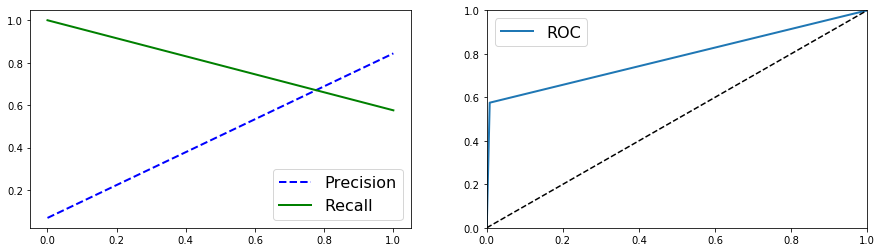

In [103]:
def plot_curves(y_train, y_train_pred):
    # create 2 subplots (horizontally stacked)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    precision, recall, f = precision_recall_curve(y_train, y_train_pred)

    fig, axarr = plt.subplots(1,2,figsize=(15,4))

    axarr[0].plot(f, precision[:-1], "b--", label="Precision", linewidth=2)
    axarr[0].plot(f, recall[:-1], "g-", label="Recall", linewidth=2)
    axarr[0].legend(loc="top", fontsize=16)

    # axarr[0].xlabel("Threshold", fontsize=16)
    # axarr[0].ylim([0, 1])

    axarr[1].plot(fpr, tpr, linewidth=2, label='ROC')
    axarr[1].plot([0, 1], [0, 1], 'k--')
    axarr[1].axis([0, 1, 0, 1])
    axarr[1].legend(loc="upper left", fontsize=16)

    plt.show()

plot_curves(y_val, y_val_pred)

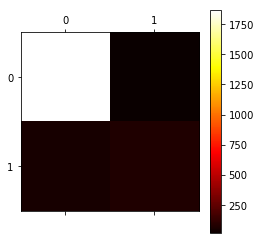

In [106]:
plt.matshow(metrics.confusion_matrix(y_val, y_val_pred), cmap=plt.cm.hot)
plt.colorbar()
plt.show()

# Answer: 
- Dealing with unbalanced dataset: 
    - Even up the training set: train the model with all of the minority class instances and an almost same amount of instances of the majority class. 

In [110]:
X_test, vc, vt = vectorizer(False, preprocessing(test), vc, vt)
y_test = test.PreventiveFlag.values

In [111]:
y_test_pred = mixed_pipe.predict(X_test)